# DCGAN implemented on MXNet Gluon

In [1]:
from __future__ import print_function
import os
import math
import mxnet as mx
from mxnet import nd, autograd
from mxnet import gluon
import numpy as np
import matplotlib.pyplot as plt
import random
import scipy.misc

## Prerequisites for Scripting

1) Install Pillow

!pip install pillow

2) Obtain the Dataset via the Google Drive link:
https://drive.google.com/open?id=0B7EVK8r0v71pZjFTYXZWM3FlRnM

Website is at http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html.

3) Extract the zip file to datasets

```
 cd SageMaker/face_generation
 mkdir dataset
 cd dataset
 unzip ../img_align_celeba.zip
 
```

4) Make an output directory
```
mkdir output
```

## Initialize the hyper parameters

In [6]:
ctx = mx.gpu() if mx.context.num_gpus() > 0 else mx.cpu()

manualSeed = random.randint(1, 10000) # manual seed 
mx.random.seed(manualSeed)



## Load the Data

In [8]:
imageSize = 64     # the height / width of the input image to network'

def transformer(data, label):
    data = mx.image.imresize(data, imageSize, imageSize)
    data = mx.nd.transpose(data, (2,0,1))
    data = data.astype(np.float32)/128.0-1.0 
    return data, label

## Create a data iterator

In [11]:
batchSize = 64

dataroot = './dataset'
train_data = gluon.data.DataLoader(
    gluon.data.vision.ImageFolderDataset(dataroot,transform=transformer),
    batch_size= batchSize, shuffle=True, last_batch='discard')

test_data = gluon.data.DataLoader(
    gluon.data.vision.ImageFolderDataset(dataroot, transform=transformer),
    batch_size=batchSize, shuffle=False, last_batch='discard')
    


## Create the Generator and Discriminator networks

![Generator Photo](./Gen.png)
![Generator and Discriminator Photo](./DG.jpeg)
Source: Radford, et al. 2015 (https://arxiv.org/abs/1511.06434)

In [20]:
G_Net = gluon.nn.Sequential()
nz = 100           # size of the latent z vector (tbe "noise" dimension)
ngf = 64
ndf = 64 
nc = 3             # Number of colors (Num input channels)

with G_Net.name_scope():
    # First layer
    G_Net.add(gluon.nn.Conv2DTranspose(channels=ngf*8, kernel_size=4, use_bias=False))
    G_Net.add(gluon.nn.BatchNorm(axis = 1, momentum = 0.1, center=True))
    G_Net.add(gluon.nn.Activation('relu'))
    
    # Second layer
    G_Net.add(gluon.nn.Conv2DTranspose(channels=ngf*4, kernel_size=4, strides = 2, padding=1, use_bias=False))
    G_Net.add(gluon.nn.BatchNorm(axis = 1, momentum = 0.1, center=True))
    G_Net.add(gluon.nn.Activation('relu'))
    
    # Third layer
    G_Net.add(gluon.nn.Conv2DTranspose(channels=ngf*2, kernel_size=4, strides=2,
                                       padding=1, use_bias=False))
    G_Net.add(gluon.nn.BatchNorm(axis = 1, momentum = 0.1, center=True))
    G_Net.add(gluon.nn.Activation('relu'))
    
    # Fourth layer
    G_Net.add(gluon.nn.Conv2DTranspose(channels=ngf, kernel_size=4, strides = 2, padding=1, use_bias=False))
    G_Net.add(gluon.nn.BatchNorm(axis = 1, momentum = 0.1, center=True))
    G_Net.add(gluon.nn.Activation('relu'))
    # Fifth layer
    G_Net.add(gluon.nn.Conv2DTranspose(channels=nc, kernel_size=4, strides=2, padding=1, use_bias=False))
    G_Net.add(gluon.nn.Activation('tanh'))

    
    
D_Net = gluon.nn.Sequential()
with D_Net.name_scope():
    # First layer
    D_Net.add(gluon.nn.Conv2D(channels=ndf, kernel_size=4, strides=2, padding=1, use_bias=False))
    D_Net.add(gluon.nn.LeakyReLU(0.2))
    
    # Second layer
    D_Net.add(gluon.nn.Conv2D(channels=ndf*2, kernel_size=4, strides=2, padding=1, use_bias=False))
    D_Net.add(gluon.nn.BatchNorm(axis = 1, momentum = 0.1, center=True))
    D_Net.add(gluon.nn.LeakyReLU(0.2))
    
    # Third layer
    D_Net.add(gluon.nn.Conv2D(channels=ndf*4, kernel_size=4,strides=2,padding=1,use_bias=False))
    D_Net.add(gluon.nn.BatchNorm(axis = 1, momentum = 0.1,center=True))
    D_Net.add(gluon.nn.LeakyReLU(0.2))
    
    # Fourth layer
    D_Net.add(gluon.nn.Conv2D(channels=ndf*8, kernel_size=4, strides=2, padding=1, use_bias=False))
    D_Net.add(gluon.nn.BatchNorm(axis = 1, momentum = 0.1,center=True))
    D_Net.add(gluon.nn.LeakyReLU(0.2))
    
    # Fifth layer
    D_Net.add(gluon.nn.Conv2D(channels=1, kernel_size=4, strides=2, padding=0, use_bias=False))
    D_Net.add(gluon.nn.Activation('sigmoid'))
    
g_net = G_Net
d_net = D_Net

## A function to visualizing the created and real images

In [14]:
outf = './output'
def image_show(data,padding = 2):
    datanp = np.clip((data.asnumpy().transpose((0, 2, 3, 1)) + 1.0)*128.0,0,255).astype(np.uint8)
    
    x_dim = min(8, batchSize)
    y_dim = int(math.ceil(float(batchSize) / x_dim))
    height, width = int(imageSize + padding), int(imageSize + padding)
    grid = np.zeros(( height * y_dim + 1 + padding // 2, width * x_dim + 1 + padding // 2,3),dtype = np.uint8)
    k = 0
    for y in range(y_dim):
        for x in range(x_dim):
            if k >= batchSize:
                break
            start_y = y * height + 1 + padding // 2
            end_y = start_y + height - padding 
            start_x = x * width + 1 + padding // 2
            end_x = start_x + width - padding
            np.copyto(grid[start_y:end_y,start_x:end_x,:],datanp[k])
            k = k + 1
    plt.figure(figsize=(10,10))
    plt.axis('off')
    plt.imshow(grid)
    plt.show()
    scipy.misc.imsave('%s/fake_samples_epoch_%03d.png' % (outf, epoch),grid)
#    plt.savefig('%s/%s/fake_samples_epoch_%03d.png' % (outf,dataset, epoch))
def binary_cross_entropy(yhat, y):
    return - (y * nd.log(yhat) + (1 - y ) * nd.log(1 - yhat))

## Initialize the networks and the optimizers

In [17]:
#Initialization
lr = 0.0001 # learning rate, default=0.0002
beta1 = 0.5 # beta1 for adam
beta2 = 0.999 # beta2 for adam
clip_gradient = 10.0

g_net.collect_params().initialize(mx.init.Normal(0.02), ctx=ctx)
d_net.collect_params().initialize(mx.init.Normal(0.02), ctx=ctx)
G_trainer = gluon.Trainer(g_net.collect_params(), 'Adam', {'learning_rate': lr * 10,'beta1':beta1,'beta2':beta2,'clip_gradient':clip_gradient})
D_trainer = gluon.Trainer(d_net.collect_params(), 'Adam', {'learning_rate': lr,'beta1':beta1,'beta2':beta2,'clip_gradient':clip_gradient})



## The learning loop

[0/0/125][0/623] Loss_D: 0.1507 Loss_G: 0.0640 D(x): 0.8818 D(G(z)): 0.9994 / 0.9404


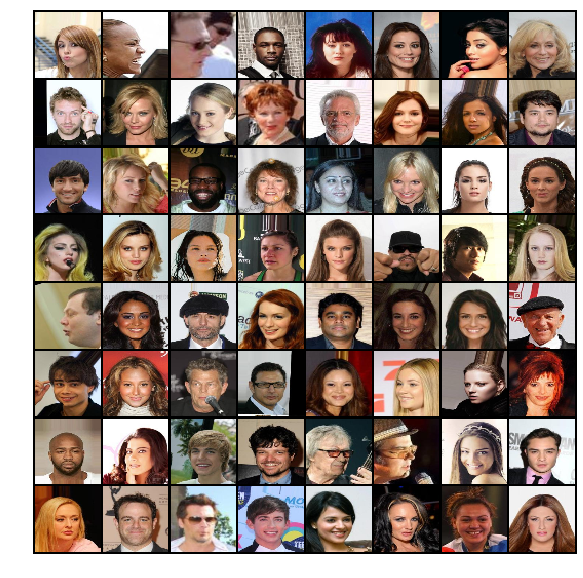

/home/ANT.AMAZON.COM/vishaalk/.local/lib/python3.6/site-packages/ipykernel_launcher.py:24: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


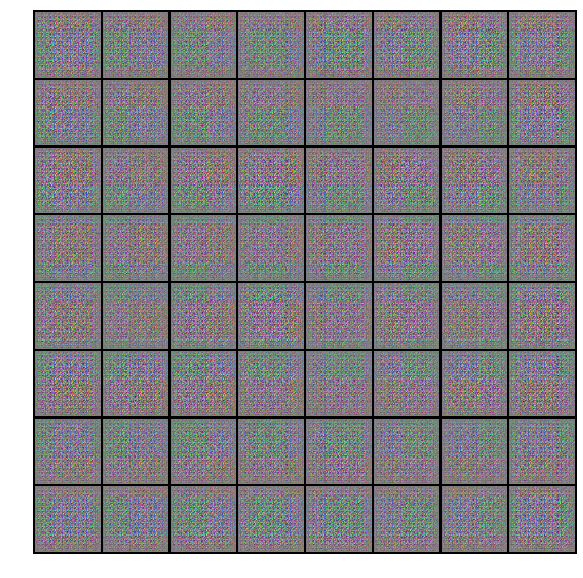

/home/ANT.AMAZON.COM/vishaalk/.local/lib/python3.6/site-packages/mxnet/gluon/block.py:346: UserWarning: save_params is deprecated. Please use save_parameters. Note that if you want load from SymbolBlock later, please use export instead. For details, see https://mxnet.incubator.apache.org/tutorials/gluon/save_load_params.html
  warnings.warn("save_params is deprecated. Please use save_parameters. "


KeyboardInterrupt: 

In [19]:
epochs = 125 # number of epochs to train for

g_net.collect_params().zero_grad()
d_net.collect_params().zero_grad()
counter = 0
for epoch in range(epochs):
    for i, (d, _ ) in enumerate(train_data):
        # Update Discriminator
        data = d.as_in_context(ctx)
        label = nd.ones(batchSize, ctx)
        noise = nd.normal(loc = 0, scale = 1, shape = (batchSize, nz,1,1),ctx = ctx)
        with autograd.record():            
            output = d_net(data)
            D_error = nd.mean(binary_cross_entropy(output,label))
            D_x = nd.mean(output)
            fake_image = g_net(noise)
            output = d_net(fake_image.detach())
            D_error_fake_image = nd.mean(binary_cross_entropy(output,label*0))
            D_G_z1 = nd.mean(output)
            D_e = D_error + D_error_fake_image
            D_e.backward()
        D_trainer.step(batchSize)
        
        # Update Generator
        label = nd.ones(batchSize, ctx)
        with autograd.record():
            fake_image = g_net(noise)
            output = d_net(fake_image)
            G_error = nd.mean(binary_cross_entropy(output,label))
            D_G_z2 = nd.mean(output)
            G_error.backward()
        G_trainer.step(batchSize)
        
        
        print('[%d/%d/%d][%d/%d] Loss_D: %.4f Loss_G: %.4f D(x): %.4f D(G(z)): %.4f / %.4f'
              % (epoch,counter, epochs, i, len(train_data),
                 D_error.asnumpy(), G_error.asnumpy(), D_x.asnumpy(), D_G_z1.asnumpy(), D_G_z2.asnumpy()))
        trunctate = 1
        if i % (100 * trunctate) == 0:
            image_show(data)
            image_show(fake_image)
        if i % (1000 * trunctate) == 0: 
            filenameG = '%s/G_Net_epoch_%d_%d' % (outf, epoch,counter)
            filenameD = '%s/D_Net_epoch_%d_%d' % (outf, epoch,counter)
            g_net.save_params(filenameG)
            d_net.save_params(filenameD)
            counter = counter + 1
    counter = 0
